# Installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/MMDS-data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark import SparkContext

sc = SparkContext(master="local", appName="final")

In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StructType, StringType, ArrayType, StructField

sqlc = SQLContext(sc)

# Câu 2:  Giảm số chiều với SVD

In [7]:
from pyspark.mllib.linalg.distributed import RowMatrix
import pandas as pd
import numpy as np

In [8]:
def reduce_dimensions(file_path, output_file, k=196):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_path, header=None)
    labels = data.iloc[:, 0]
    features = data.iloc[:, 1:]

    # Chuyển đổi dữ liệu thành RowMatrix
    rows = sc.parallelize(features.values)
    mat = RowMatrix(rows)

    # Tính toán SVD và giảm số chiều
    svd = mat.computeSVD(k, computeU=True)
    U = svd.U
    s = svd.s
    V = svd.V
    
    U = np.array(U.rows.collect())
    s = np.array(s)
    V = np.array(V.toArray()).transpose()[:, :k]

    reduced_matrix = U @ np.diag(s) @ V
    # Lưu kết quả vào file CSV
    reduced_data = pd.concat([labels, pd.DataFrame(reduced_matrix)], axis=1)
    reduced_data.to_csv(output_file, index=False, header=False)
    sc.stop()

In [9]:
#Câu 2_1: Giảm số chiều tập train
reduce_dimensions('/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train.csv', '/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train_svd.csv')

In [12]:
#Câu 2_2: Giảm số chiều tập test
reduce_dimensions('/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test.csv', '/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test_svd.csv')

# Câu 5: Phân loại đa lớp với pyspark

## Sử dụng tập train, test ban đầu

In [7]:
from pyspark.ml.linalg import Vectors as ml_vectors
import numpy as np
def f(x):
  k = x.split(',')
  return int(k[0]), ml_vectors.dense(np.array(k[1:]).astype(int))

In [8]:
train_data = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train.csv").map(f).toDF(['label', 'features'])
test_data = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test.csv").map(f).toDF(['label', 'features'])

In [9]:
train_set, val_data = train_data.randomSplit([0.8, 0.2], seed=42)

### MLP

In [10]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [784, 256, 128, 10]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42)

In [11]:
model_mlp = mlp.fit(train_set)

In [12]:
# tính accuracy trên val_data
result = model_mlp.transform(val_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_mlp = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_mlp = evaluator_val_mlp.evaluate(predictionAndLabels)
print("MLP Validation set accuracy = " + str(accuracy_val_mlp))

MLP Validation set accuracy = 0.9214659685863874


In [13]:
# Tính accuracy trên test_data
result = model_mlp.transform(test_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_mlp = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_mlp = evaluator_test_mlp.evaluate(predictionAndLabels)
print("MLP Test set accuracy = " + str(accuracy_test_mlp))

MLP Test set accuracy = 0.9283333333333333


### Random Forest

In [14]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50, seed=1234, maxDepth=10)

In [15]:
model_rf = rf.fit(train_set)

In [16]:
# tính accuracy trên val_data
result = model_rf.transform(val_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_rf = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_rf = evaluator_val_rf.evaluate(predictionAndLabels)
print("Random Forest Validation set accuracy = " + str(accuracy_val_rf))

Random Forest Validation set accuracy = 0.9334330590875094


In [17]:
# Tính accuracy trên test_data
result = model_rf.transform(test_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_rf = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_rf = evaluator_test_rf.evaluate(predictionAndLabels)
print("Random Forest Test set accuracy = " + str(accuracy_test_rf))

Random Forest Test set accuracy = 0.95


### Linear Support Vector Machine

#### LSVC phân biệt số 0

In [18]:
from pyspark.sql.functions import when, col
# label khác 0 thì thay = 1, 0 thì giữ nguyên 0 (otherwise(0))
test_data_0 = test_data.withColumn("label", when(col("label") != 0, 1).otherwise(0))
train_set_0 = train_set.withColumn("label", when(col("label") != 0, 1).otherwise(0))
val_data_0 = val_data.withColumn("label", when(col("label") != 0, 1).otherwise(0))

In [19]:
from pyspark.ml.classification import LinearSVC

# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_0 = lsvc.fit(train_set_0)

In [20]:
# tính accuracy trên val_data
result = model_lsvc_0.transform(val_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_0 = evaluator_val_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 0 = " + str(accuracy_val_lsvc_0))

Linear Support Vector Machine Validation set accuracy prediction 0 = 0.9895287958115183


In [21]:
# Tính accuracy trên test_data
result = model_lsvc_0.transform(test_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_0 = evaluator_test_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 0 = " + str(accuracy_test_lsvc_0))

Linear Support Vector Machine Test set accuracy prediction 0 = 0.992


#### LSVC phân biệt số 1

In [22]:
test_data_1 = test_data.withColumn("label", when(col("label") != 1, 0).otherwise(1))
train_set_1 = train_set.withColumn("label", when(col("label") != 1, 0).otherwise(1))
val_data_1 = val_data.withColumn("label", when(col("label") != 1, 0).otherwise(1))

In [23]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_1 = lsvc.fit(train_set_1)

In [24]:
# tính accuracy trên val_data
result = model_lsvc_1.transform(val_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_1 = evaluator_val_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 1 = " + str(accuracy_val_lsvc_1))

Linear Support Vector Machine Validation set accuracy prediction 1 = 0.9902767389678384


In [25]:
# Tính accuracy trên test_data
result = model_lsvc_1.transform(test_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_1 = evaluator_test_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 1 = " + str(accuracy_test_lsvc_1))

Linear Support Vector Machine Test set accuracy prediction 1 = 0.993


#### LSVC phân biệt số 2

In [26]:
test_data_2 = test_data.withColumn("label", when(col("label") != 2, 0).otherwise(1))
train_set_2 = train_set.withColumn("label", when(col("label") != 2, 0).otherwise(1))
val_data_2 = val_data.withColumn("label", when(col("label") != 2, 0).otherwise(1))

In [27]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_2 = lsvc.fit(train_set_2)

In [28]:
# tính accuracy trên val_data
result = model_lsvc_2.transform(val_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_2 = evaluator_val_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 2 = " + str(accuracy_val_lsvc_2))

Linear Support Vector Machine Validation set accuracy prediction 2 = 0.9730740463724757


In [29]:
# Tính accuracy trên test_data
result = model_lsvc_2.transform(test_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_2 = evaluator_test_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 2 = " + str(accuracy_test_lsvc_2))

Linear Support Vector Machine Test set accuracy prediction 2 = 0.9726666666666667


#### LSVC phân biệt số 3

In [30]:
test_data_3 = test_data.withColumn("label", when(col("label") != 3, 0).otherwise(1))
train_set_3 = train_set.withColumn("label", when(col("label") != 3, 0).otherwise(1))
val_data_3 = val_data.withColumn("label", when(col("label") != 3, 0).otherwise(1))

In [31]:
model_lsvc_3 = lsvc.fit(train_set_3)

In [32]:
# tính accuracy trên val_data
result = model_lsvc_3.transform(val_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_3 = evaluator_val_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 3 = " + str(accuracy_val_lsvc_3))

Linear Support Vector Machine Validation set accuracy prediction 3 = 0.9805534779356769


In [33]:
# Tính accuracy trên test_data
result = model_lsvc_3.transform(test_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_3 = evaluator_test_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 3 = " + str(accuracy_test_lsvc_3))

Linear Support Vector Machine Test set accuracy prediction 3 = 0.9783333333333334


#### LSVC phân biệt số 4

In [34]:
test_data_4 = test_data.withColumn("label", when(col("label") != 4, 0).otherwise(1))
train_set_4 = train_set.withColumn("label", when(col("label") != 4, 0).otherwise(1))
val_data_4 = val_data.withColumn("label", when(col("label") != 4, 0).otherwise(1))

In [35]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_4 = lsvc.fit(train_set_4)

In [36]:
# tính accuracy trên val_data
result = model_lsvc_4.transform(val_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_4 = evaluator_val_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 4 = " + str(accuracy_val_lsvc_4))

Linear Support Vector Machine Validation set accuracy prediction 4 = 0.975317875841436


In [37]:
# Tính accuracy trên test_data
result = model_lsvc_4.transform(test_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_4 = evaluator_test_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 4 = " + str(accuracy_test_lsvc_4))

Linear Support Vector Machine Test set accuracy prediction 4 = 0.9786666666666667


#### LSVC phân biệt số 5

In [38]:
test_data_5 = test_data.withColumn("label", when(col("label") != 5, 0).otherwise(1))
train_set_5 = train_set.withColumn("label", when(col("label") != 5, 0).otherwise(1))
val_data_5 = val_data.withColumn("label", when(col("label") != 5, 0).otherwise(1))

In [39]:
model_lsvc_5 = lsvc.fit(train_set_5)

In [40]:
# tính accuracy trên val_data
result = model_lsvc_5.transform(val_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_5 = evaluator_val_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 5 = " + str(accuracy_val_lsvc_5))

Linear Support Vector Machine Validation set accuracy prediction 5 = 0.9738219895287958


In [41]:
# Tính accuracy trên test_data
result = model_lsvc_5.transform(test_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_5 = evaluator_test_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 5 = " + str(accuracy_test_lsvc_5))

Linear Support Vector Machine Test set accuracy prediction 5 = 0.9696666666666667


#### LSVC phân biệt số 6

In [42]:
test_data_6 = test_data.withColumn("label", when(col("label") != 6, 0).otherwise(1))
train_set_6 = train_set.withColumn("label", when(col("label") != 6, 0).otherwise(1))
val_data_6 = val_data.withColumn("label", when(col("label") != 6, 0).otherwise(1))

In [43]:
model_lsvc_6 = lsvc.fit(train_set_6)

In [44]:
# tính accuracy trên val_data
result = model_lsvc_6.transform(val_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_6 = evaluator_val_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 6 = " + str(accuracy_val_lsvc_6))

Linear Support Vector Machine Validation set accuracy prediction 6 = 0.9730740463724757


In [45]:
# Tính accuracy trên test_data
result = model_lsvc_6.transform(test_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_6 = evaluator_test_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 6 = " + str(accuracy_test_lsvc_6))

Linear Support Vector Machine Test set accuracy prediction 6 = 0.9886666666666667


#### LSVC phân biệt số 7

In [46]:
test_data_7 = test_data.withColumn("label", when(col("label") != 7, 0).otherwise(1))
train_set_7 = train_set.withColumn("label", when(col("label") != 7, 0).otherwise(1))
val_data_7 = val_data.withColumn("label", when(col("label") != 7, 0).otherwise(1))

In [47]:
model_lsvc_7 = lsvc.fit(train_set_7)

In [48]:
# tính accuracy trên val_data
result = model_lsvc_7.transform(val_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_7 = evaluator_val_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 7 = " + str(accuracy_val_lsvc_7))

Linear Support Vector Machine Validation set accuracy prediction 7 = 0.9745699326851159


In [49]:
# Tính accuracy trên test_data
result = model_lsvc_7.transform(test_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_7 = evaluator_test_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 7 = " + str(accuracy_test_lsvc_7))

Linear Support Vector Machine Test set accuracy prediction 7 = 0.9923333333333333


#### LSVC phân biệt số 8

In [50]:
test_data_8 = test_data.withColumn("label", when(col("label") != 8, 0).otherwise(1))
train_set_8 = train_set.withColumn("label", when(col("label") != 8, 0).otherwise(1))
val_data_8 = val_data.withColumn("label", when(col("label") != 8, 0).otherwise(1))

In [51]:
model_lsvc_8 = lsvc.fit(train_set_8)

In [52]:
# tính accuracy trên val_data
result = model_lsvc_8.transform(val_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_8 = evaluator_val_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 8 = " + str(accuracy_val_lsvc_8))

Linear Support Vector Machine Validation set accuracy prediction 8 = 0.9648466716529543


In [53]:
# Tính accuracy trên test_data
result = model_lsvc_8.transform(test_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_8 = evaluator_test_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 8 = " + str(accuracy_test_lsvc_8))

Linear Support Vector Machine Test set accuracy prediction 8 = 0.968


#### LSVC phân biệt số 9

In [54]:
test_data_9 = test_data.withColumn("label", when(col("label") != 9, 0).otherwise(1))
train_set_9 = train_set.withColumn("label", when(col("label") != 9, 0).otherwise(1))
val_data_9 = val_data.withColumn("label", when(col("label") != 9, 0).otherwise(1))

In [55]:
model_lsvc_9 = lsvc.fit(train_set_9)

In [56]:
# tính accuracy trên val_data
result = model_lsvc_9.transform(val_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_9 = evaluator_val_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 9 = " + str(accuracy_val_lsvc_9))

Linear Support Vector Machine Validation set accuracy prediction 9 = 0.9573672400897532


In [57]:
# Tính accuracy trên test_data
result = model_lsvc_9.transform(test_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_9 = evaluator_test_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 9 = " + str(accuracy_test_lsvc_9))

Linear Support Vector Machine Test set accuracy prediction 9 = 0.9626666666666667


In [67]:
# trung bình cộng tất cả LSVC
accuracy_val_lsvc_arr = []
accuracy_test_lsvc_arr = []

for i in range(10):
  var_name_val = eval(f"accuracy_val_lsvc_{i}")
  var_name_test = eval(f"accuracy_test_lsvc_{i}")
  accuracy_val_lsvc_arr.append(var_name_val)
  accuracy_test_lsvc_arr.append(var_name_test)

accuracy_val_lsvc = sum(accuracy_val_lsvc_arr) / len(accuracy_val_lsvc_arr)
accuracy_test_lsvc = sum(accuracy_test_lsvc_arr) / len(accuracy_test_lsvc_arr)
print("Linear Support Vector Machine Validation set accuracy = " + str(accuracy_val_lsvc))
print("Linear Support Vector Machine Test set accuracy = " + str(accuracy_test_lsvc))

Linear Support Vector Machine Validation set accuracy = 0.9752430815258041
Linear Support Vector Machine Test set accuracy = 0.9796000000000001


## Sử dụng tập training_svd, test_svd từ câu b)

In [68]:
def f(x):
  k = x.split(',')
  return int(k[0]), ml_vectors.dense(np.array(k[1:]))

In [69]:
train_data_svd = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train_svd.csv").map(f).toDF(['label', 'features'])
test_data_svd = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test_svd.csv").map(f).toDF(['label', 'features'])

In [70]:
train_set_svd, val_data_svd = train_data_svd.randomSplit([0.8, 0.2], seed=42)

### MLP

In [71]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [196, 256, 128, 10]
mlp_svd = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42)

In [72]:
model_mlp_svd = mlp_svd.fit(train_set_svd)

In [73]:
# tính accuracy trên val_data
result = model_mlp_svd.transform(val_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_mlp_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_mlp_svd = evaluator_val_mlp_svd.evaluate(predictionAndLabels)
print("MLP Validation SVD set accuracy = " + str(accuracy_val_mlp_svd))

MLP Validation SVD set accuracy = 0.6013462976813763


In [74]:
# Tính accuracy trên test_data
result = model_mlp_svd.transform(test_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_mlp_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_mlp_svd = evaluator_test_mlp_svd.evaluate(predictionAndLabels)
print("MLP Test SVD set accuracy = " + str(accuracy_test_mlp_svd))

MLP Test SVD set accuracy = 0.5556666666666666


### Random Forest

In [75]:
from pyspark.ml.classification import RandomForestClassifier

rf_svd = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50, seed=1234, maxDepth=10)

In [76]:
model_rf_svd = rf_svd.fit(train_set_svd)

In [77]:
# tính accuracy trên val_data
result = model_rf_svd.transform(val_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_rf_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_rf_svd = evaluator_val_rf_svd.evaluate(predictionAndLabels)
print("Random Forest Validation SVD set accuracy = " + str(accuracy_val_rf_svd))

Random Forest Validation SVD set accuracy = 0.6192969334330591


In [78]:
# Tính accuracy trên test_data
result = model_rf_svd.transform(test_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_rf_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_rf_svd = evaluator_test_rf_svd.evaluate(predictionAndLabels)
print("Random Forest Test SVD set accuracy = " + str(accuracy_test_rf_svd))

Random Forest Test SVD set accuracy = 0.5713333333333334


### Linear Support Vector Machine

#### LSVC phân biệt số 0

In [79]:
from pyspark.sql.functions import when, col
# label khác 0 thì thay = 1, 0 thì giữ nguyên 0 (otherwise(0))
test_data_0 = test_data_svd.withColumn("label", when(col("label") != 0, 1).otherwise(0))
train_set_0 = train_set_svd.withColumn("label", when(col("label") != 0, 1).otherwise(0))
val_data_0 = val_data_svd.withColumn("label", when(col("label") != 0, 1).otherwise(0))

In [80]:
from pyspark.ml.classification import LinearSVC

# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_0 = lsvc.fit(train_set_0)

In [81]:
# tính accuracy trên val_data
result = model_lsvc_0.transform(val_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_0 = evaluator_val_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation SVD set accuracy prediction 0 = " + str(accuracy_val_lsvc_0))

Linear Support Vector Machine Validation SVD set accuracy prediction 0 = 0.9184741959611069


In [82]:
# Tính accuracy trên test_data
result = model_lsvc_0.transform(test_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_0 = evaluator_test_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test SVD set accuracy prediction 0 = " + str(accuracy_test_lsvc_0))

Linear Support Vector Machine Test SVD set accuracy prediction 0 = 0.48133333333333334


#### LSVC phân biệt số 1

In [83]:
test_data_1 = test_data_svd.withColumn("label", when(col("label") != 1, 0).otherwise(1))
train_set_1 = train_set_svd.withColumn("label", when(col("label") != 1, 0).otherwise(1))
val_data_1 = val_data_svd.withColumn("label", when(col("label") != 1, 0).otherwise(1))

In [84]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_1 = lsvc.fit(train_set_1)

In [85]:
# tính accuracy trên val_data
result = model_lsvc_1.transform(val_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_1 = evaluator_val_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation SVD set accuracy prediction 1 = " + str(accuracy_val_lsvc_1))

Linear Support Vector Machine Validation SVD set accuracy prediction 1 = 0.8915482423335827


In [86]:
# Tính accuracy trên test_data
result = model_lsvc_1.transform(test_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_1 = evaluator_test_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test SVD set accuracy prediction 1 = " + str(accuracy_test_lsvc_1))

Linear Support Vector Machine Test SVD set accuracy prediction 1 = 0.5003333333333333


#### LSVC phân biệt số 2

In [87]:
test_data_2 = test_data_svd.withColumn("label", when(col("label") != 2, 0).otherwise(1))
train_set_2 = train_set_svd.withColumn("label", when(col("label") != 2, 0).otherwise(1))
val_data_2 = val_data_svd.withColumn("label", when(col("label") != 2, 0).otherwise(1))

In [88]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_2 = lsvc.fit(train_set_2)

In [89]:
# tính accuracy trên val_data
result = model_lsvc_2.transform(val_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_2 = evaluator_val_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 2 = " + str(accuracy_val_lsvc_2))

Linear Support Vector Machine Validation set accuracy prediction 2 = 0.9184741959611069


In [90]:
# Tính accuracy trên test_data
result = model_lsvc_2.transform(test_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_2 = evaluator_test_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 2 = " + str(accuracy_test_lsvc_2))

Linear Support Vector Machine Test set accuracy prediction 2 = 0.5066666666666667


#### LSVC phân biệt số 3

In [91]:
test_data_3 = test_data_svd.withColumn("label", when(col("label") != 3, 0).otherwise(1))
train_set_3 = train_set_svd.withColumn("label", when(col("label") != 3, 0).otherwise(1))
val_data_3 = val_data_svd.withColumn("label", when(col("label") != 3, 0).otherwise(1))

In [92]:
model_lsvc_3 = lsvc.fit(train_set_3)

In [93]:
# tính accuracy trên val_data
result = model_lsvc_3.transform(val_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_3 = evaluator_val_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 3 = " + str(accuracy_val_lsvc_3))

Linear Support Vector Machine Validation set accuracy prediction 3 = 0.8945400149588631


In [94]:
# Tính accuracy trên test_data
result = model_lsvc_3.transform(test_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_3 = evaluator_test_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 3 = " + str(accuracy_test_lsvc_3))

Linear Support Vector Machine Test set accuracy prediction 3 = 0.5153333333333333


#### LSVC phân biệt số 4

In [95]:
test_data_4 = test_data_svd.withColumn("label", when(col("label") != 4, 0).otherwise(1))
train_set_4 = train_set_svd.withColumn("label", when(col("label") != 4, 0).otherwise(1))
val_data_4 = val_data_svd.withColumn("label", when(col("label") != 4, 0).otherwise(1))

In [96]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_4 = lsvc.fit(train_set_4)

In [97]:
# tính accuracy trên val_data
result = model_lsvc_4.transform(val_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_4 = evaluator_val_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 4 = " + str(accuracy_val_lsvc_4))

Linear Support Vector Machine Validation set accuracy prediction 4 = 0.8967838444278234


In [98]:
# Tính accuracy trên test_data
result = model_lsvc_4.transform(test_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_4 = evaluator_test_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 4 = " + str(accuracy_test_lsvc_4))

Linear Support Vector Machine Test set accuracy prediction 4 = 0.5016666666666667


#### LSVC phân biệt số 5

In [99]:
test_data_5 = test_data_svd.withColumn("label", when(col("label") != 5, 0).otherwise(1))
train_set_5 = train_set_svd.withColumn("label", when(col("label") != 5, 0).otherwise(1))
val_data_5 = val_data_svd.withColumn("label", when(col("label") != 5, 0).otherwise(1))

In [100]:
model_lsvc_5 = lsvc.fit(train_set_5)

In [101]:
# tính accuracy trên val_data
result = model_lsvc_5.transform(val_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_5 = evaluator_val_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 5 = " + str(accuracy_val_lsvc_5))

Linear Support Vector Machine Validation set accuracy prediction 5 = 0.9229618548990277


In [102]:
# Tính accuracy trên test_data
result = model_lsvc_5.transform(test_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_5 = evaluator_test_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 5 = " + str(accuracy_test_lsvc_5))

Linear Support Vector Machine Test set accuracy prediction 5 = 0.48733333333333334


#### LSVC phân biệt số 6

In [103]:
test_data_6 = test_data_svd.withColumn("label", when(col("label") != 6, 0).otherwise(1))
train_set_6 = train_set_svd.withColumn("label", when(col("label") != 6, 0).otherwise(1))
val_data_6 = val_data_svd.withColumn("label", when(col("label") != 6, 0).otherwise(1))

In [104]:
model_lsvc_6 = lsvc.fit(train_set_6)

In [105]:
# tính accuracy trên val_data
result = model_lsvc_6.transform(val_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_6 = evaluator_val_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 6 = " + str(accuracy_val_lsvc_6))

Linear Support Vector Machine Validation set accuracy prediction 6 = 0.9506357516828721


In [106]:
# Tính accuracy trên test_data
result = model_lsvc_6.transform(test_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_6 = evaluator_test_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 6 = " + str(accuracy_test_lsvc_6))

Linear Support Vector Machine Test set accuracy prediction 6 = 0.53


#### LSVC phân biệt số 7

In [107]:
test_data_7 = test_data_svd.withColumn("label", when(col("label") != 7, 0).otherwise(1))
train_set_7 = train_set_svd.withColumn("label", when(col("label") != 7, 0).otherwise(1))
val_data_7 = val_data_svd.withColumn("label", when(col("label") != 7, 0).otherwise(1))

In [108]:
model_lsvc_7 = lsvc.fit(train_set_7)

In [109]:
# tính accuracy trên val_data
result = model_lsvc_7.transform(val_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_7 = evaluator_val_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 7 = " + str(accuracy_val_lsvc_7))

Linear Support Vector Machine Validation set accuracy prediction 7 = 0.893792071802543


In [110]:
# Tính accuracy trên test_data
result = model_lsvc_7.transform(test_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_7 = evaluator_test_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 7 = " + str(accuracy_test_lsvc_7))

Linear Support Vector Machine Test set accuracy prediction 7 = 0.4696666666666667


#### LSVC phân biệt số 8

In [111]:
test_data_8 = test_data_svd.withColumn("label", when(col("label") != 8, 0).otherwise(1))
train_set_8 = train_set_svd.withColumn("label", when(col("label") != 8, 0).otherwise(1))
val_data_8 = val_data_svd.withColumn("label", when(col("label") != 8, 0).otherwise(1))

In [112]:
model_lsvc_8 = lsvc.fit(train_set_8)

In [113]:
# tính accuracy trên val_data
result = model_lsvc_8.transform(val_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_8 = evaluator_val_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 8 = " + str(accuracy_val_lsvc_8))

Linear Support Vector Machine Validation set accuracy prediction 8 = 0.9072550486163051


In [114]:
# Tính accuracy trên test_data
result = model_lsvc_8.transform(test_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_8 = evaluator_test_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 8 = " + str(accuracy_test_lsvc_8))

Linear Support Vector Machine Test set accuracy prediction 8 = 0.478


#### LSVC phân biệt số 9

In [115]:
test_data_9 = test_data_svd.withColumn("label", when(col("label") != 9, 0).otherwise(1))
train_set_9 = train_set_svd.withColumn("label", when(col("label") != 9, 0).otherwise(1))
val_data_9 = val_data_svd.withColumn("label", when(col("label") != 9, 0).otherwise(1))

In [132]:
model_lsvc_9 = lsvc.fit(train_set_9)

In [133]:
# tính accuracy trên val_data
result = model_lsvc_9.transform(val_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_9 = evaluator_val_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 9 = " + str(accuracy_val_lsvc_9))

Linear Support Vector Machine Validation set accuracy prediction 9 = 0.8975317875841436


In [118]:
# Tính accuracy trên test_data
result = model_lsvc_9.transform(test_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_9 = evaluator_test_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 9 = " + str(accuracy_test_lsvc_9))

Linear Support Vector Machine Test set accuracy prediction 9 = 0.526


In [119]:
# trung bình cộng tất cả LSVC
accuracy_val_lsvc_arr = []
accuracy_test_lsvc_arr = []

for i in range(10):
  var_name_val = eval(f"accuracy_val_lsvc_{i}")
  var_name_test = eval(f"accuracy_test_lsvc_{i}")
  accuracy_val_lsvc_arr.append(var_name_val)
  accuracy_test_lsvc_arr.append(var_name_test)

accuracy_val_lsvc_svd = sum(accuracy_val_lsvc_arr) / len(accuracy_val_lsvc_arr)
accuracy_test_lsvc_svd = sum(accuracy_test_lsvc_arr) / len(accuracy_test_lsvc_arr)
print("Linear Support Vector Machine Validation SVD set accuracy = " + str(accuracy_val_lsvc_svd))
print("Linear Support Vector Machine Test SVD set accuracy = " + str(accuracy_test_lsvc_svd))

Linear Support Vector Machine Validation SVD set accuracy = 0.9091997008227375
Linear Support Vector Machine Test SVD set accuracy = 0.4996333333333333


## Thể hiện độ chính xác (visualize)


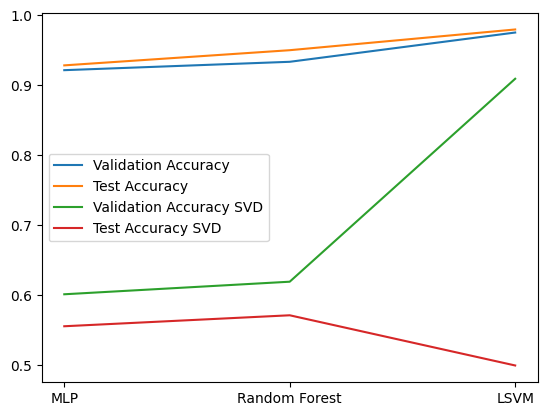

In [129]:
import matplotlib.pyplot as plt

val_acc = [accuracy_val_mlp, accuracy_val_rf, accuracy_val_lsvc]
test_acc = [accuracy_test_mlp, accuracy_test_rf, accuracy_test_lsvc]
val_acc_svd = [accuracy_val_mlp_svd, accuracy_val_rf_svd, accuracy_val_lsvc_svd]
test_acc_svd = [accuracy_test_mlp_svd, accuracy_test_rf_svd, accuracy_test_lsvc_svd]

# Đặt tên cho các model
models = ['MLP', 'Random Forest', 'LSVM']

plt.plot(models, val_acc, label='Validation Accuracy')
plt.plot(models, test_acc, label='Test Accuracy')
plt.plot(models, val_acc_svd, label='Validation Accuracy SVD')
plt.plot(models, test_acc_svd, label='Test Accuracy SVD')
plt.legend()
plt.show()